# Minimum code for Extended Data Figure 5c qPCR panel

In [1]:
options(warn = -1)
suppressPackageStartupMessages({
  library(tidyverse)
  library(rasilabRtemplates)
})

In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Read in annotations

In [3]:
annotations <- read_csv("../annotations/sampleannotations.csv") %>% 
  mutate(Well = as.character(Well),
         Plate = as.character(Plate)) %>%
  print()

Rows: 108 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Well, Amplicon, sgRNA, Treatment
dbl (1): Plate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 108 × 5
   Plate Well  Amplicon sgRNA    Treatment
   <chr> <chr> <chr>    <chr>    <chr>    
 1 4     A01   GAPDH    GCN1-1_2 DMSO     
 2 4     A02   GAPDH    GCN1-1_2 100nM    
 3 4     A03   GAPDH    GCN1-1_2 1μM      
 4 4     A04   GAPDH    GCN1-3_4 DMSO     
 5 4     A05   GAPDH    GCN1-3_4 100nM    
 6 4     A06   GAPDH    GCN1-3_4 1μM      
 7 4     A07   GAPDH    FLUC-1_2 DMSO     
 8 4     A08   GAPDH    FLUC-1_2 100nM    
 9 4     A09   GAPDH    FLUC-1_2 1μM      
10 4     B01   GAPDH    GCN1-1_2 DMSO     
# … with 98 more rows


## Read in Cq data from Cfx Duet

In [4]:
cq_data <- list.files("../../../../data/qpcr/u937_gcn1_hht/", full.names = T) %>% 
   as_tibble_col("file") %>%
   mutate(data = map(file, . %>% read_csv() %>% as_tibble)) %>%
   mutate(Plate = str_extract(file, "(?<=plate)\\d")) %>%
   unnest("data") %>%
   select(Cq, Well, Plate) %>%
   rename(CT = Cq) %>%
   inner_join(annotations) %>%
   filter(!is.na(CT)) %>%
   # Remove outlier
   mutate(platewell = str_c(Plate, Well)) %>%
   filter(platewell != "7F07") %>%
   select(CT, Amplicon, sgRNA, Treatment) %>%
   mutate(Treatment = fct_relevel(Treatment, "DMSO")) %>%
   print()

New names:
• `` -> `...1`
Rows: 96 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Well, Fluor, Content
dbl (8): Cq, Cq Mean, Cq Std. Dev, Starting Quantity (SQ), Log Starting Quan...
lgl (5): ...1, Target, Sample, Biological Set Name, Well Note

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 81 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Well, Fluor, Content
dbl (8): Cq, Cq Mean, Cq Std. Dev, Starting Quantity (SQ), Log Starting Quan...
lgl (5): ...1, Target, Sample, Biological Set Name, Well Note

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("Well", "Plate")


# A tibble: 107 × 4
      CT Amplicon sgRNA    Treatment
   <dbl> <chr>    <chr>    <fct>    
 1  22.1 GAPDH    GCN1-1_2 DMSO     
 2  21.1 GAPDH    GCN1-1_2 100nM    
 3  22.1 GAPDH    GCN1-1_2 1μM      
 4  21.0 GAPDH    GCN1-3_4 DMSO     
 5  20.7 GAPDH    GCN1-3_4 100nM    
 6  22.0 GAPDH    GCN1-3_4 1μM      
 7  20.8 GAPDH    FLUC-1_2 DMSO     
 8  20.6 GAPDH    FLUC-1_2 100nM    
 9  21.0 GAPDH    FLUC-1_2 1μM      
10  22.0 GAPDH    GCN1-1_2 DMSO     
# … with 97 more rows


## Normalize expression to GAPDH

In [7]:
norm_ct_inverted <- cq_data  %>%
  filter(!is.na(CT)) %>%
  group_by(Amplicon, Treatment, sgRNA) %>%
  summarize(std_error = sd(CT),
            n = n(),
            CT = mean(CT)) %>%
  ungroup() %>%
  group_by(Treatment, sgRNA) %>%
  mutate(norm_ct = CT - CT[Amplicon == "GAPDH"],
         norm_error = sqrt(std_error^2 + std_error[Amplicon == "GAPDH"]^2)) %>%
  filter(Amplicon != "GAPDH") %>%
  mutate(norm_ct = 10 - norm_ct) %>%
  write_csv("../../../../source_data/figure_s5c.csv") %>%
  print()

`summarise()` has grouped output by 'Amplicon', 'Treatment'. You can override
using the `.groups` argument.


# A tibble: 18 × 8
# Groups:   Treatment, sgRNA [9]
   Amplicon Treatment sgRNA    std_error     n    CT norm_ct norm_error
   <chr>    <fct>     <chr>        <dbl> <int> <dbl>   <dbl>      <dbl>
 1 EGR1     DMSO      FLUC-1_2    0.810      3  35.8   -4.73     0.841 
 2 EGR1     DMSO      GCN1-1_2    0.212      3  35.5   -3.47     0.238 
 3 EGR1     DMSO      GCN1-3_4    0.475      3  35.6   -4.57     0.478 
 4 EGR1     100nM     FLUC-1_2    0.554      3  33.3   -2.62     0.557 
 5 EGR1     100nM     GCN1-1_2    0.163      3  29.1    2.05     0.185 
 6 EGR1     100nM     GCN1-3_4    0.340      3  28.3    2.64     0.391 
 7 EGR1     1μM       FLUC-1_2    0.261      3  32.6   -1.31     0.331 
 8 EGR1     1μM       GCN1-1_2    0.576      3  26.9    5.34     0.613 
 9 EGR1     1μM       GCN1-3_4    0.163      2  27.9    4.18     0.212 
10 JUN      DMSO      FLUC-1_2    0.0367     3  28.7    2.29     0.227 
11 JUN      DMSO      GCN1-1_2    0.133      3  28.9    3.08     0.172 
12 JUN      

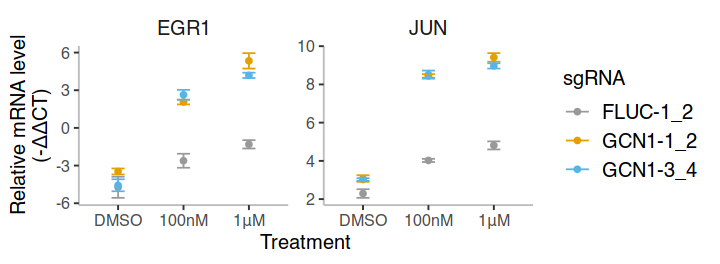

In [6]:
options(repr.plot.width=6, repr.plot.height=2.2)

norm_ct_inverted %>% 
  ggplot(aes(x = Treatment, y = norm_ct, ymax = norm_ct + norm_error, ymin = norm_ct - norm_error, color = sgRNA)) +
  geom_point() +
  geom_errorbar(width = 0.2) +
  facet_wrap(~Amplicon, scales = "free_y") +
  ylab("Relative mRNA level\n(-ΔΔCT)") +
  theme(axis.text.x = element_text(),
        axis.line = element_line(color = "grey")) +
  scale_color_manual(values = cbPalette) 

ggsave("../figures/egr1_jun_mrna_levels.pdf", height = 2.2, width = 6) 